<h1><center> 
AutoML-assisted toehold switch MFE predictor using self optimizing genetic programming pipelines 
</center></h1>

<center>
Luis R. Soenksen<sup>1,2*</sup>, Nicolaas M Angenent-Mari<sup>1,2*</sup> Diogo M. Camacho<sup>2*</sup>, Alexander S. Garruss<sup>2,3*</sup>, Katherine M Collins<sup>1*</sup>, Sameed Siddiqui<sup>1,2</sup>, George Church<sup>1,2,3,4</sup>, Timothy K. Lu<sup>1,4</sup>, and James J. Collins<sup>1,2,3,4</sup>
</center>


<center><font color=gray><font size="1.5">
<sup>1</sup>Massachusetts Institute of Technology, <sup>2</sup>Wyss Institute for Biologically Inspired Engineering, <sup>3</sup>Harvard John A. Paulson School of Engineering and Applied Sciences, and <sup>4</sup>Broad Institute of MIT and Harvard. *Contributed equally
</font></font></center>


##### Abstract:
<font color=black><font size="2">
A benchmark tool in the field of synthetic biology is the RNA “Toehold-Switch”, a riboregulator that responds to a programmable target to change its secondary structure through strand displacement with up-regulation of a desired protein. Recent advances have streamlined the synthesis of these modules; however, in vitro and in vivo functionality remain highly unpredictable due to complex interactions unanticipated by standard base-pairing models. We are developing and testing aa high-quality library of 250,000 toehold sequences to train and optimize a variety of machine-learning and deep-learning models (e.g. MLPs, CNN, RNN) to enable accurate biological predictions of novel toehold sensor functionality.
</font></font>

---------------------------------------------------------------------------------------------

#### This code requires the following pre-installs:
> ##### Biopython
> In anaconda env: `conda install -c anaconda biopython` or `pip install biopython`<br>
> Ref: https://github.com/biopython/biopython
> ##### ViennaRNA
> In anaconda env: `conda install -c bioconda viennarna`<br>
> Ref: https://github.com/ViennaRNA/ViennaRNA
> ##### Pysster (Python 3.5+)
> In anaconda env: `pip3 install pysster`<br>
> Ref: https://github.com/budach/pysste
> ##### Tpot
> In anaconda env: `conda install -c conda-forge tpot`<br>
> Ref: https://github.com/EpistasisLab/tpot
> ##### Dask
> In anaconda env: `conda install dask`<br>
> Ref: https://docs.dask.org/en/latest/
> ##### Graphviz
> In anaconda env: `conda install graphviz`<br>
> Ref: https://pypi.org/project/graphviz/

References on "Evaluation of a Tree-based Pipeline Optimization Tool (TPOT) for Automating Data Science":

> Randal S. Olson, Ryan J. Urbanowicz, Peter C. Andrews, Nicole A. Lavender, La Creis Kidd, and Jason H. Moore (2016). Automating biomedical data science through tree-based pipeline optimization. Applications of Evolutionary Computation, pages 123-137.

>Randal S. Olson, Nathan Bartley, Ryan J. Urbanowicz, and Jason H. Moore (2016). Evaluation of a Tree-based Pipeline Optimization Tool for Automating Data Science. Proceedings of GECCO 2016, pages 485-492.

---------------------------------------------------------------------------------------------

#### DATA STRUCTURE (INPUT / OUTPU)
> Data is loaded from a Toehold Sensor Database (data/2019-01-18_toehold_dataset.csv) which is comma delimited table  having the following columns of DNA encoded sub-sequences:
organism, sequence_class, sequence_id, pre_seq	promoter, trigger, loop1, switch, loop2, stem1, atg, stem2m linkerm post_linker, output	
> #### Inpu vectors for all models can be defined in 3 distinct ways (DS=Data_Style):
> **DS_1)**  Single DNA Sequence Input Vector / Trigger-ONLY / 30-nucleotides <br>
> **DS_2)** Two Independent DNA Sequences as Input Vectors / ON & OFF states of toehold / OFF is 59 nucleotides / ON is 59+50=109 nucleotides <br>
> **DS_3)** Two Independent DNA Extended Sequences as Input Vectors / ON & OFF states of toehold / OFF is 59+40=85 nucleotides / ON is 59+50+85=194 nucleotides <br> 
> *NOTE: pre_seq & promoter sub-sequences are NEVER used because they are not converted into mRNA (is in the plasmid but it is never in the functional toehold module), so it won't contribute in secondary structure at all. For this example in particular we use DS_1.*

> #### Output is defined as:
> **OUT_1)** Minimum free energy (MFE) of the RNA derived from the switch DNA sequence which is the real part that contributs to toehold functionality

#### PROBLEM DEFINITION
> Something very valuable to investigate for is to know if any of the input vector types (DS_1, DS_2 or DS_3) can be fed to a network to predict switch MFE. We would also want to know if training with DS_3 is better than with DS_2, of if DS_2 is also better than than DS_1, because in that case it would suggest the network is learning secondary structure prediction that would be transferable to other RNA based problems.

In [1]:
## Import Libraries
# General system libraries
import os
import numpy as np
import pandas as pd
from time import time
from IPython.display import Image

# Multiprocessing
import multiprocessing

# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# ViennaRNA Lib
import RNA
# pysster Lib
from pysster import utils
from pysster.Data import Data
from pysster.Grid_Search import Grid_Search
from pysster.One_Hot_Encoder import One_Hot_Encoder
from pysster.Alphabet_Encoder import Alphabet_Encoder

# Import TPOT libs
from tpot import TPOTRegressor

# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score

# Math & Visualization Libs
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Warnings
import warnings

Using TensorFlow backend.


### Import Dataset
Let's see what our file look like

In [2]:
# Create Data folder if not existent
data_folder = "data/"
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)

# Define path to load desired Toehold dataset file (.csv)
data_filename = "2019-02-06_toehold_dataset_proc_on_off.csv"
data_path = data_folder + data_filename
data = pd.read_csv(data_path)

#Show dataframe
data.head()

,off_id,on_id,source_sequence,sequence_id,pre_seq,promoter,trigger,loop1,switch,loop2,...,Cbn2_on,Cbn3_on,Cbn4_on,Cbn1_off,Cbn2_off,Cbn3_off,Cbn4_off,ON,OFF,ON_OFF
0,AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...,TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...,smallpoxsmallpox,smallpox_tile_6492smallpox_tile_6492,CTCTGGGCTAACTGTCGCGCCTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGGTAATACGACTCACTATAGGG,TCCAAGTAGTAGTCCTACGTTATTTTTTTTTCCAAGTAGTAGTCCT...,AACAACAACAAACAAAACAACAACAAACAA,AAAAAAAATAACGTAGGACTACTACTTGGAAAAAAAAATAACGTAG...,AACAGAGGAGAAACAGAGGAGA,...,0.591829,0.119432,0.055509,0.075791,0.810190,0.114019,0.000000,0.332407,0.346076,-0.013669
1,AACCAAACACACAAACGCACAAAAAAAATTTGGATTTATTTATGTC...,ATGAGACATAAATAAATCCAAATTTTTTTTAACCAAACACACAAAC...,smallpoxsmallpox,smallpox_tile_19684smallpox_tile_19684,CTCTGGGCTAACTGTCGCGCCTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGGTAATACGACTCACTATAGGG,ATGAGACATAAATAAATCCAAATTTTTTTTATGAGACATAAATAAA...,AACAACAACAAACAAAACAACAACAAACAA,AAAAAAAATTTGGATTTATTTATGTCTCATAAAAAAAATTTGGATT...,AACAGAGGAGAAACAGAGGAGA,...,1.000000,0.000000,0.000000,0.244214,0.725170,0.030616,0.000000,0.333333,0.262134,0.071199
2,AACCAAACACACAAACGCACAAAAAAACATGAGCTTTGCTTTTTTC...,ACTTGAAAAAAGCAAAGCTCATGTTTTTTTAACCAAACACACAAAC...,human_PROX1human_PROX1,human_PROX1_tile_176human_PROX1_tile_176,CTCTGGGCTAACTGTCGCGCCTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGGTAATACGACTCACTATAGGG,ACTTGAAAAAAGCAAAGCTCATGTTTTTTTACTTGAAAAAAGCAAA...,AACAACAACAAACAAAACAACAACAAACAA,AAAAAAACATGAGCTTTGCTTTTTTCAAGTAAAAAAACATGAGCTT...,AACAGAGGAGAAACAGAGGAGA,...,0.000000,0.121780,0.802118,0.150849,0.161256,0.595710,0.092185,0.883305,0.543077,0.340228
3,AACCAAACACACAAACGCACAAAAAAAGATTTTTTTCCGATGTTGA...,TGTATCAACATCGGAAAAAAATCTTTTTTTAACCAAACACACAAAC...,smallpoxsmallpox,smallpox_tile_7220smallpox_tile_7220,CTCTGGGCTAACTGTCGCGCCTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGGTAATACGACTCACTATAGGG,TGTATCAACATCGGAAAAAAATCTTTTTTTTGTATCAACATCGGAA...,AACAACAACAAACAAAACAACAACAAACAA,AAAAAAAGATTTTTTTCCGATGTTGATACAAAAAAAAGATTTTTTT...,AACAGAGGAGAAACAGAGGAGA,...,0.139674,0.459203,0.307549,0.000000,0.136372,0.863628,0.000000,0.660242,0.621209,0.039033
4,AACCAAACACACAAACGCACAAAAAAATGATTTCCATATCTTTGAT...,ACCCATCAAAGATATGGAAATCATTTTTTTAACCAAACACACAAAC...,smallpoxsmallpox,smallpox_tile_8336smallpox_tile_8336,CTCTGGGCTAACTGTCGCGCCTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGGTAATACGACTCACTATAGGG,ACCCATCAAAGATATGGAAATCATTTTTTTACCCATCAAAGATATG...,AACAACAACAAACAAAACAACAACAAACAA,AAAAAAATGATTTCCATATCTTTGATGGGTAAAAAAATGATTTCCA...,AACAGAGGAGAAACAGAGGAGA,...,0.105460,0.587911,0.024022,0.377289,0.604974,0.017737,0.000000,0.451116,0.213483,0.237633


In [3]:
### Sequence ID data selection from main DataFrame
id_data = data['sequence_id']

### DNA Nucleotide dataset input selection and concatenation using different datastyles (i.e DS_1, DS_2, DS_3)
# Data Style #1 (trigger only)
#df_data_input = data['trigger']
#df_data_output = data['target']

# Data Style #2 (base ON/OFF)
#df_off_data_input = data['switch'] + data['loop2'] + data['stem1'] + data['atg'] + data['stem2']
#df_on_data_input = data['trigger'] + data['loop1'] + data['switch'] + data['loop2'] + data['stem1'] + data['atg'] + data['stem2']
df_data_input = data['switch'] + data['loop2'] + data['stem1'] + data['atg'] + data['stem2']
df_data_output = data['ON_OFF']

# Data Style #3 (extended ON/OFF)
#df_off_data_input = data['switch'] + data['loop2'] + data['stem1'] + data['atg'] + data['stem2'] + data['linker'] + data['post_linker']
#df_on_data_input = data['trigger'] + data['loop1'] + data['switch'] + data['loop2'] + data['stem1'] + data['atg'] + data['stem2'] + data['linker'] + data['post_linker']
#df_data_output = data['target']

print("Number of sequences retrieved: "+str(len(data.index)))
print()
print('Examples of Input Vector:')
print(' ' + str(df_data_input[0]))
print()
print('Examples of Output Vector:')
print(' ' + str(df_data_output[0]))

Number of sequences retrieved: 30101

Examples of Input Vector:
 AAAAAAAATAACGTAGGACTACTACTTGGAAAAAAAAATAACGTAGGACTACTACTTGGAAACAGAGGAGAAACAGAGGAGATCCAAGTCCAAGATGATGTAGTCCTACTAGTCCTAC

Examples of Output Vector:
 -0.013669396


In [4]:
## Prepare and save base FASTA file with id's and nucleotide sequence data only
input_file = (data_folder + data_filename.replace('.csv','.fasta')) 
records = (SeqRecord(Seq(str(seq), generic_dna), str(index),'',str(id_data[int(index)])) for index, seq in enumerate(df_data_input))
print('Sequences saved to FASTA: ')
SeqIO.write(records, input_file, "fasta")

Sequences saved to FASTA: 


30101

In [5]:
# ONE-HOT encode input sequences
# Define 4-letter alphabet "ACGT" and Convert input dataset
n_data_input = []
one_data_input = []
oh_data_input = []
one = One_Hot_Encoder("ACGT")
for index, seq in df_data_input.items():
    n_data_input.append((np.asarray(list(seq))))
    one_hot_seq = one.encode(seq)                           #ONE HOT ENCODE, and then
    oh_data_input.append(np.transpose(one_hot_seq))               
    one_data_input.append(np.argmax((one_hot_seq), axis=1)) #To numerical for TPOT

#Print sample
print('Sample DNA Seq String:')
print(df_data_input[0])
print()
print('Sample DNA Seq Vector:')
print(n_data_input[0])
print()
print('One-Hot Version:')
print(oh_data_input[0])
print()
print('Categorical/numerical Version:')
print(one_data_input[0])

Sample DNA Seq String:
AAAAAAAATAACGTAGGACTACTACTTGGAAAAAAAAATAACGTAGGACTACTACTTGGAAACAGAGGAGAAACAGAGGAGATCCAAGTCCAAGATGATGTAGTCCTACTAGTCCTAC

Sample DNA Seq Vector:
['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'T' 'A' 'A' 'C' 'G' 'T' 'A' 'G' 'G' 'A'
 'C' 'T' 'A' 'C' 'T' 'A' 'C' 'T' 'T' 'G' 'G' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'T' 'A' 'A' 'C' 'G' 'T' 'A' 'G' 'G' 'A' 'C' 'T' 'A' 'C' 'T' 'A'
 'C' 'T' 'T' 'G' 'G' 'A' 'A' 'A' 'C' 'A' 'G' 'A' 'G' 'G' 'A' 'G' 'A' 'A'
 'A' 'C' 'A' 'G' 'A' 'G' 'G' 'A' 'G' 'A' 'T' 'C' 'C' 'A' 'A' 'G' 'T' 'C'
 'C' 'A' 'A' 'G' 'A' 'T' 'G' 'A' 'T' 'G' 'T' 'A' 'G' 'T' 'C' 'C' 'T' 'A'
 'C' 'T' 'A' 'G' 'T' 'C' 'C' 'T' 'A' 'C']

One-Hot Version:
[[1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1
  1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1
  1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1
  0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0

Distribution of normalized output
MinVal = -1.0(0.0), MaxVal = 1.0(1.0)


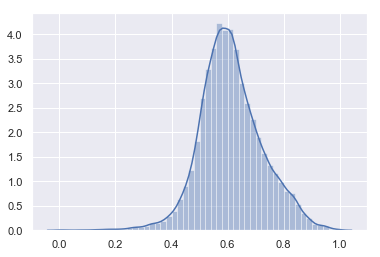

In [6]:
# Normalize output vector
x = df_data_output.values #returns a numpy array
x = x.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm_data_output = x_scaled.ravel()

# Display Normalized Output distribution
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(color_codes=True)
print('Distribution of normalized output')
print('MinVal = ' + str(min(df_data_output))+ '(0.0), ' +
      'MaxVal = ' + str(max(df_data_output))+ '(1.0)')

sns.distplot(norm_data_output, kde=True, rug=False)
plt.show()

---------------------------------------------------------------------------------------------

## Automated Machine Learning Model Discovery using Genetic Programming

This approach uses [TPOT](https://epistasislab.github.io/tpot/api/), a Python library developed for automatic machine learning feature preprocessing, model selection, and hyperparameter tuning. TPOT uses [genetic programming](http://geneticprogramming.com/tutorial/) to find the best machine learning pipeline for a dataset by evaluating thousands of possibilites. 

The machine learning pipeline in this context consists of:

1. Feature Preprocessing
  * Imputing missing values and scaling values
  * Constructing new features such as polynomial transformations
2. Feature selection
  * Dimensionality reduction, for example using PCA and other techniques
3. Model Selection
  * Evaluting a number of machine learning models
4. Hyperparameter tuning
  * Finding the optimal settings of the model for the particular problem

TPOT is one of a class of artificial intelligence (AI) methods known as [auto-ml (short for automated machine learning)](https://www.kdnuggets.com/2017/01/current-state-automated-machine-learning.html) which aims to simplify the work of the data scientist by automatically finding the optimal (or near-optimal) feature preprocessing steps and model for the problem. Machine learning is  typically a very time-consuming and knowledge-intensive part of a data science problem. Auto-ml is not designed to replace the data scientist, but rather free her to work on more important aspects of the complete problem, such as acquiring data and interpreting the model results. In effect, TPOT, and auto-ml in general, will in effect be a "data science assistant" that will be another tool among many used by data scientists. Machine learning is only one part of the data science process, and it still takes a human to weave the different aspects of a problem together into a complete working product.

Other entries in the field of auto - ml include:
* [Auto-sklearn](https://automl.github.io/auto-sklearn/stable/)
* [H20](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html)
* [Google Cloud AutoML](https://cloud.google.com/automl/)

In [7]:
# Supervised REGRESSION problem for toehold design using TPOT

# Divide dataset into training and testing sets
data_input = one_data_input 
data_output = norm_data_output
print('Dataset has input shape:'+ str(np.shape(data_input)) + ', and output shape: '+ str(np.shape(data_output)))

# Define Train and Test ratios
train_size = 0.75
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(data_input, data_output,train_size=train_size, test_size=test_size)
print('Data split into Train(' + str(train_size*100) + '%) and Test(' + str(test_size*100) +'%) sets')   

Dataset has input shape:(30101, 118), and output shape: (30101,)
Data split into Train(75.0%) and Test(25.0%) sets


In [8]:
# Train TPOT classifier (multiprocessing)
# Ref: https://epistasislab.github.io/tpot/api/
tpot = TPOTRegressor(generations = 5, 
                     population_size = 50,
                     n_jobs = -1,
                     max_time_mins = 120,
                     max_eval_time_mins = 5,
                     #config_dict = 'TPOT MDR',
                     periodic_checkpoint_folder = 'models/',
                     verbosity = 3)

# TPOT SETTINGS:
#   > generations = Number of iterations to the run pipeline optimization process.
#   > population_size = Number of individuals to retain in the genetic programming population every generation.
#   > offspring_size = Number of offspring to produce in each genetic programming generation. 
#   > mutation_rate = Mutation rate for the genetic programming algorithm in the range [0.0, 1.0].
#   > crossover_rate Crossover rate for the genetic programming algorithm in the range [0.0, 1.0].
#   > scoring = Function used to evaluate the quality of a given pipeline for the regression problem.
#               Note that it is recommended to use the neg version of mean squared error and related 
#               metrics so TPOT will minimize (instead of maximize) the metric. 
#   > cv = Cross-validation strategy used when evaluating pipelines. 
#   > subsample = Fraction of training samples that are used during the TPOT optimization process. 
#   > n_jobs = Number of processes to use in parallel for evaluating pipelines during the TPOT optimization process. 
#   > max_time_mins = How many minutes TPOT has to optimize the pipeline. 
#   > max_eval_time_mins = How many minutes TPOT has to evaluate a single pipeline. 
#   > random_state = The seed of the pseudo random number generator used in TPOT. 
#   > config_dict = A configuration dictionary for customizing the TPOT operators and parameters
#          Possible inputs are:
#               Python dictionary, TPOT will use your custom configuration,
#               string 'TPOT light', TPOT will use a built-in configuration with only fast models and preprocessors, or
#               string 'TPOT MDR', TPOT will use a built-in configuration specialized for genomic studies, or
#               string 'TPOT sparse': TPOT will use a configuration dictionary with a one-hot encoder and the operators normally included in TPOT that also support sparse matrices, or
#               None, TPOT will use the default TPOTRegressor configuration.
#   > warm_start = Flag indicating whether the TPOT instance will reuse the population from previous calls to fit(). 
#   > memory = If supplied, pipeline will cache each transformer after calling fit. 
#   > use_dask = Whether to use Dask-ML's pipeline optimiziations. 
#   > periodic_checkpoint_folder = f supplied, a folder in which TPOT will periodically save the best pipeline so far while optimizing.
#   > early_stop = How many generations TPOT checks whether there is no improvement in optimization process. 
#   > verbosity = How much information TPOT communicates while it's running. 
#   > disable_update_check = Flag indicating whether the TPOT version checker should be disabled.                      
#    Note: You can check the input parameters of regrtessor of classifier in 
#          https://epistasislab.github.io/tpot/api/

In [9]:
# Run traning
tpot.fit(X_train, y_train)

# Print last obtaned R2 score after pipeline discovery
print(tpot.score(X_test, y_test))

29 operators have been imported by TPOT.


Skipped pipeline #28 due to time out. Continuing to the next pipeline.
Saving best periodic pipeline to models/pipeline_2019.02.07_12-43-50.py
_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 87
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


TPOT 

In [10]:
# Create Models folder if not existent
model_folder = "models/"
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

# Define path to save TPOT optimized predictive model (.py)
model_filename = "optimized_tpot_pipeline.py"
model_path = model_folder + model_filename

In [11]:
# Save TPOT optimized predictive model (.py)
tpot.export(model_path)

True

### Features
Let's see what our features vectors look like

In [12]:
data_input_feature_names = [('n_' + str(item)) for item in list(range(len(one_data_input[0])))]
data_tpot = pd.DataFrame(data_input, columns=data_input_feature_names)
display(data_tpot.head())

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_108,n_109,n_110,n_111,n_112,n_113,n_114,n_115,n_116,n_117
0,0,0,0,0,0,0,0,0,3,0,...,1,3,0,2,3,1,1,3,0,1
1,0,0,0,0,0,0,0,0,3,3,...,1,0,0,0,3,0,0,0,3,1
2,0,0,0,0,0,0,0,1,0,3,...,1,0,0,2,1,0,0,0,2,1
3,0,0,0,0,0,0,0,2,0,3,...,0,0,3,1,2,2,0,0,0,0
4,0,0,0,0,0,0,0,3,2,0,...,0,0,2,0,3,0,3,2,2,0


### Target
Let's see what our target that we would like to predict looks like

In [13]:
target_tpot = pd.DataFrame(norm_data_output)
target_tpot.rename(columns={0: 'target'}, inplace=True)
display(target_tpot.head())

,target
0,0.493165
1,0.535600
2,0.670114
3,0.519516
4,0.618817


### Save data to csv
TPOT requires a local data file. We're going to save it to `data/__________tpot.csv`

In [14]:
data_path_tpot = (data_folder + data_filename.replace('.csv','_tpot.csv')) 
tpot_tmp = pd.concat([data_tpot, target_tpot], axis=1, join_axes=[data_tpot.index])
tpot_tmp.to_csv(data_path_tpot, index=False)
display(tpot_tmp.head())

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_109,n_110,n_111,n_112,n_113,n_114,n_115,n_116,n_117,target
0,0,0,0,0,0,0,0,0,3,0,...,3,0,2,3,1,1,3,0,1,0.493165
1,0,0,0,0,0,0,0,0,3,3,...,0,0,0,3,0,0,0,3,1,0.535600
2,0,0,0,0,0,0,0,1,0,3,...,0,0,2,1,0,0,0,2,1,0.670114
3,0,0,0,0,0,0,0,2,0,3,...,0,3,1,2,2,0,0,0,0,0.519516
4,0,0,0,0,0,0,0,3,2,0,...,0,2,0,3,0,3,2,2,0,0.618817


### Read TPOT discovered model definition (exported  .py code) and train on data
This code does a quick check to make sure data was written the right way for use with `'models/optimized_tpot_pipeline.py'`.

In [15]:
##-----------------------------------------------------------------------------------------------
##------------------- IMPORTED CODE FROM LATEST "tpot_*******_pipeline.py" ----------------------
#

import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.builtins import OneHotEncoder

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = np.recfromcsv(data_path_tpot, dtype=np.float64)
features = np.delete(tpot_data.view(np.float64).reshape(tpot_data.size, -1), tpot_data.dtype.names.index('target'), axis=1)

training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was:-0.0007189100616268919
exported_pipeline = make_pipeline(
    OneHotEncoder(minimum_fraction=0.1, sparse=False, threshold=10),
    RidgeCV()
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

#
##---------------------------------- END OF IMPORTED CODE ---------------------------------------
##-----------------------------------------------------------------------------------------------

In [16]:
print('TPOT Pipeline Definition:')
print(exported_pipeline)

TPOT Pipeline Definition:
Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,...None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False))])


In [17]:
# plot feature importance
%matplotlib inline
import seaborn as sns
from xgboost import plot_importance, plot_tree
sns.set(font_scale = 1)
ax = plot_importance(booster = exported_pipeline,
                ax=None, 
                height=1, 
                xlim=None, 
                ylim=None, 
                title='Feature importance', 
                xlabel='F score', 
                ylabel='Features', 
                importance_type='weight', 
                max_num_features=None, 
                grid=False, 
                show_values=True)

ax.figure.set_size_inches(10,8)
plt.show()

print('TPOT Pipeline Graph:')
n_trees = 10
for tree in range(n_subplots):
    print('>> Tree #' + str(tree))
    plot_tree(exported_pipeline, num_trees=tree, rankdir='LR')
    fig = plt.gcf()
    fig.set_size_inches(100, 100)
    fig.savefig(model_path.replace('.py','.png'))
    plt.figure(figsize=(10000,10000))
    plt.show()

ValueError: tree must be Booster, XGBModel or dict instance

### Performance (Score) of discovered model
Here we propose to use an R2 score primarily, which is basically a normalized (to variance) metric of mean squared error (ranging from 0 to 1). R2=0 indicates that the model explains none of the variability of the response data around its mean, while R2=1 indicates that the model explains all the variability of the response data around its mean. Other scores are also presented.

In [ ]:
# TPOT performance for TRAINING & TESTING sets 
# The following scores are used:
    # >> Explained variance regression function (Good > 0.5)
    # >> Mean absolute error regression loss
    # >> Mean squared error regression loss
    # >> Mean squared logarithmic error regression loss
    # >> Median absolute error regression loss
    # >> R^2 (coefficient of determination) regression score function.
    # REF: https://scikit-learn.org/stable/modules/model_evaluation.html
    
training_results = exported_pipeline.predict(training_features)
testing_results = exported_pipeline.predict(testing_features)

# Calculate TPOT model performance scores on Training set: 
y_true = np.array(training_target)
y_pred = np.array(training_results)

tpot_training_evs = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
tpot_training_mae = mean_absolute_error(y_true, y_pred)
tpot_training_mse = mean_squared_error(y_true, y_pred)  
tpot_training_mle = mean_squared_log_error(y_true, y_pred) 
tpot_training_dle = median_absolute_error(y_true, y_pred)
tpot_training_r2s = r2_score(y_true, y_pred, multioutput='variance_weighted') 


# Calculate TPOT model performance on Training set: 
y_true = np.array(testing_target)
y_pred = np.array(testing_results)

tpot_testing_evs = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
tpot_testing_mae = mean_absolute_error(y_true, y_pred)
tpot_testing_mse = mean_squared_error(y_true, y_pred)  
tpot_testing_mle = mean_squared_log_error(y_true, y_pred) 
tpot_testing_dle = median_absolute_error(y_true, y_pred)
tpot_testing_r2s = r2_score(y_true, y_pred, multioutput='variance_weighted') 


#Calculate R2 score directly from TPOT to compare/confirm  "sklearn" algorithms:
tpot_training_r2s_base = exported_pipeline.score(training_features, training_target)
tpot_testing_r2s_base  = exported_pipeline.score(testing_features, testing_target)

if (tpot_training_r2s == tpot_training_r2s_base)and(tpot_testing_r2s == tpot_testing_r2s_base):
    print("Everything looks appropiately calculated (Sklearn r2 scores matches TPOT r2 score)")
else:
    print("Score calculation missmatch, please revise!")

In [ ]:
#Display All performance scores in single table
score_column_names = ['Training (TPOT)', 'Testing (TPOT)']
score_row_names    = ['Explained Variance',
                      'Mean absolute error',
                      'Mean squared error',
                      'Mean squared log error',
                      'Median absolute error',
                      'R^2 (sklearn, tpot)' ]

score_matrix = [[tpot_training_evs , tpot_testing_evs],
                [tpot_training_mae , tpot_testing_mae],
                [tpot_training_mse , tpot_testing_mse],
                [tpot_training_mle , tpot_testing_mle],
                [tpot_training_dle , tpot_testing_dle],
                [tpot_training_r2s , tpot_testing_r2s]]

tpot_score_df = pd.DataFrame(score_matrix, columns=score_column_names, index=score_row_names)
display(tpot_score_df)

### Comparison with manually produced regressor
For comparison, we will produce a benchmark regressor manually and then we will calculate the same scores

In [ ]:
##-----------------------------------------------------------------------------------------------
##------------------- RANDOM MODEL USING DECISION TREES (BENCHMARK)  ----------------------------
#

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    score = r2_score(y_true, y_predict)
    return score

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
    regressor = DecisionTreeRegressor(random_state=42)
    params = {'max_depth' : np.array(range(1,10))}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor, cv=cv_sets, param_grid=params, scoring=scoring_fnc)
    grid = grid.fit(X, y)
    return grid.best_estimator_

reg = fit_model(training_features, training_target)
print("Standard Model created and estimated!")

#
##---------------------------------- END OF MODEL CODE ------------------------------------------
##-----------------------------------------------------------------------------------------------

In [ ]:
# Standard model performance for TRAINING & TESTING sets 
# The following scores are used:
    # >> Explained variance regression function (Good > 0.5)
    # >> Mean absolute error regression loss
    # >> Mean squared error regression loss
    # >> Mean squared logarithmic error regression loss
    # >> Median absolute error regression loss
    # >> R^2 (coefficient of determination) regression score function.
    # REF: https://scikit-learn.org/stable/modules/model_evaluation.html
    
training_results = reg.predict(training_features)
testing_results = reg.predict(testing_features)

# Calculate Standard model performance scores on Training set: 
y_true = np.array(training_target)
y_pred = np.array(training_results)

std_training_evs = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
std_training_mae = mean_absolute_error(y_true, y_pred)
std_training_mse = mean_squared_error(y_true, y_pred)  
std_training_mle = mean_squared_log_error(y_true, y_pred) 
std_training_dle = median_absolute_error(y_true, y_pred)
std_training_r2s = r2_score(y_true, y_pred, multioutput='variance_weighted') 


# Calculate Standard model performance on Training set: 
y_true = np.array(testing_target)
y_pred = np.array(testing_results)

std_testing_evs = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
std_testing_mae = mean_absolute_error(y_true, y_pred)
std_testing_mse = mean_squared_error(y_true, y_pred)  
std_testing_mle = mean_squared_log_error(y_true, y_pred) 
std_testing_dle = median_absolute_error(y_true, y_pred)
std_testing_r2s = r2_score(y_true, y_pred, multioutput='variance_weighted') 


#Display All performance scores in single table
score_column_names = ['Training (STD)', 'Testing (STD)']
score_row_names    = ['Explained Variance',
                      'Mean absolute error',
                      'Mean squared error',
                      'Mean squared log error',
                      'Median absolute error',
                      'R^2 (sklearn, tpot)']

score_matrix = [[std_training_evs , std_testing_evs],
                [std_training_mae , std_testing_mae],
                [std_training_mse , std_testing_mse],
                [std_training_mle , std_testing_mle],
                [std_training_dle , std_testing_dle],
                [std_training_r2s , std_testing_r2s]]

std_score_df = pd.DataFrame(score_matrix, columns=score_column_names, index=score_row_names)
display(std_score_df)

------------------------------------------------------------------------------------------------------------

### Summary of comparative r2 scores (Standard vs TPOT)

The following summarizes the scores from the pipeline created by tpot and a comparision with a decisiontree.

In [ ]:
print('PERFORMANCE OF REGRESSOR MODELS')
score_column_names = ['Standard (r2)', 'TPOT (r2)']
score_row_names    = ['Train',
                      'Test',]

score_matrix = [[std_training_r2s , tpot_training_r2s],
                [std_testing_r2s  , tpot_testing_r2s]]

score_df = pd.DataFrame(score_matrix, columns=score_column_names, index=score_row_names)
display(score_df)

------------------------------------------------------------------------------------------------------------

### Performance (Score) of discovered model on random data outputs
Here we propose to use an R2 score primarily, which is basically a normalized (to variance) metric of mean squared error (ranging from 0 to 1). R2=0 indicates that the model explains none of the variability of the response data around its mean, while R2=1 indicates that the model explains all the variability of the response data around its mean. Other scores are also presented.

In [24]:
random_data_output = data['random_mfe']

# Normalize output vector
x = random_data_output.values #returns a numpy array
x = x.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
random_norm_data_output = x_scaled.ravel()

In [25]:
random_target_tpot = pd.DataFrame(random_norm_data_output)
random_target_tpot.rename(columns={0: 'random_mfe'}, inplace=True)
display(random_target_tpot.head())

,random_mfe
0,0.817640
1,0.840286
2,0.853397
3,0.846246
4,0.885578


In [26]:
# NOTE: Make sure that the class is labeled 'random_mfe' in the data file
random_training_features, random_testing_features, random_training_target, random_testing_target = \
            train_test_split(features, random_target_tpot, random_state=None)

In [27]:
# TPOT performance for TRAINING & TESTING sets 
# The following scores are used:
    # >> Explained variance regression function (Good > 0.5)
    # >> Mean absolute error regression loss
    # >> Mean squared error regression loss
    # >> Mean squared logarithmic error regression loss
    # >> Median absolute error regression loss
    # >> R^2 (coefficient of determination) regression score function.
    # REF: https://scikit-learn.org/stable/modules/model_evaluation.html
    
random_training_results = exported_pipeline.predict(random_training_features)
random_testing_results = exported_pipeline.predict(random_testing_features)

# Calculate TPOT model performance scores on Training set: 
y_true = np.array(random_training_target)
y_pred = np.array(random_training_results)

tpot_training_evs = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
tpot_training_mae = mean_absolute_error(y_true, y_pred)
tpot_training_mse = mean_squared_error(y_true, y_pred)  
tpot_training_mle = mean_squared_log_error(y_true, y_pred) 
tpot_training_dle = median_absolute_error(y_true, y_pred)
tpot_training_r2s = r2_score(y_true, y_pred, multioutput='variance_weighted') 


# Calculate TPOT model performance on Training set: 
y_true = np.array(random_testing_target)
y_pred = np.array(random_testing_results)

tpot_testing_evs = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
tpot_testing_mae = mean_absolute_error(y_true, y_pred)
tpot_testing_mse = mean_squared_error(y_true, y_pred)  
tpot_testing_mle = mean_squared_log_error(y_true, y_pred) 
tpot_testing_dle = median_absolute_error(y_true, y_pred)
tpot_testing_r2s = r2_score(y_true, y_pred, multioutput='variance_weighted') 


#Calculate R2 score directly from TPOT to compare/confirm  "sklearn" algorithms:
tpot_training_r2s_base = exported_pipeline.score(random_training_features, random_training_target)
tpot_testing_r2s_base  = exported_pipeline.score(random_testing_features, random_testing_target)

if (tpot_training_r2s == tpot_training_r2s_base)and(tpot_testing_r2s == tpot_testing_r2s_base):
    print("Everything looks appropiately calculated (Sklearn r2 scores matches TPOT r2 score)")
else:
    print("Score calculation missmatch, please revise!")

Everything looks appropiately calculated (Sklearn r2 scores matches TPOT r2 score)


In [28]:
#Display All performance scores in single table
score_column_names = ['Training (RAND-TPOT)', 'Testing (RAND-TPOT)']
score_row_names    = ['Explained Variance',
                      'Mean absolute error',
                      'Mean squared error',
                      'Mean squared log error',
                      'Median absolute error',
                      'R^2 (sklearn, tpot)' ]

score_matrix = [[tpot_training_evs , tpot_testing_evs],
                [tpot_training_mae , tpot_testing_mae],
                [tpot_training_mse , tpot_testing_mse],
                [tpot_training_mle , tpot_testing_mle],
                [tpot_training_dle , tpot_testing_dle],
                [tpot_training_r2s , tpot_testing_r2s]]

tpot_score_df = pd.DataFrame(score_matrix, columns=score_column_names, index=score_row_names)
display(tpot_score_df)

,Training (RAND-TPOT),Testing (RAND-TPOT)
Explained Variance,-6.811434,-6.593092
Mean absolute error,0.307403,0.306990
Mean squared error,0.113355,0.112828
Mean squared log error,0.041312,0.041061
Median absolute error,0.305626,0.305734
"R^2 (sklearn, tpot)",-44.332131,-43.482532


------------------------------------------------------------------------------------------------------------